# Actual Evapotranspiration

In [1]:
from pathlib import Path

import networkx as nx
import osmnx as ox
import pandas as pd

import pygeohydro as gh
from pynhd import NLDI

The daily actual evapotranspiration can be retrieved from [SEEBop](https://earlywarning.usgs.gov/ssebop/modis/daily) database. Note that since this service does not offer a web service and data are available as raster files on the server, so this function is not as fast as other functions and download speed might be the bottleneck.

You can get the actual ET for position-based requests using ``ssebopeta_bycoords`` and for geometry-based requests using ``ssebopeta_bygeom``.

Now, let's see `ssebopeta_bycoords` in action. The coordinates must be a dataframe with three columns: ``id``, ``x``, and ``y``. Let's use [osmnx](https://github.com/gboeing/osmnx) package to get a street network:

In [2]:
G = ox.graph_from_place("Piedmont, California, USA", network_type="drive")

Now, we can get land cover and tree canopy for each node based on their coordinates and then plot the results. 

In [3]:
dates = ("2005-10-01", "2005-10-05")
x, y = nx.get_node_attributes(G, "x"), nx.get_node_attributes(G, "y")
coords = pd.DataFrame({"id": x.keys(), "x": x.values(), "y": y.values()})
ds = gh.ssebopeta_bycoords(coords, dates=dates)

The function returns a ``xarray.Dataset``:

In [4]:
ds

<xarray.Dataset>
Dimensions:      (time: 5, location_id: 348)
Coordinates:
  * time         (time) datetime64[ns] 2005-10-01 2005-10-02 ... 2005-10-05
  * location_id  (location_id) int64 53017091 53018397 ... 9656853491 9656853494
Data variables:
    eta          (time, location_id) float64 0.551 0.551 0.551 ... 0.551 0.551
    x            (location_id) float64 -122.2 -122.2 -122.2 ... -122.2 -122.2
    y            (location_id) float64 37.83 37.82 37.82 ... 37.82 37.82 37.82

Let's add the average value of obtained ETAs to the street nodes:

In [5]:
eta_m = ds.mean(dim="time").eta
eta_dict = {sid: eta_m.sel(location_id=sid).item() for sid in eta_m.location_id.values}
nx.set_node_attributes(G, eta_dict, "eta")

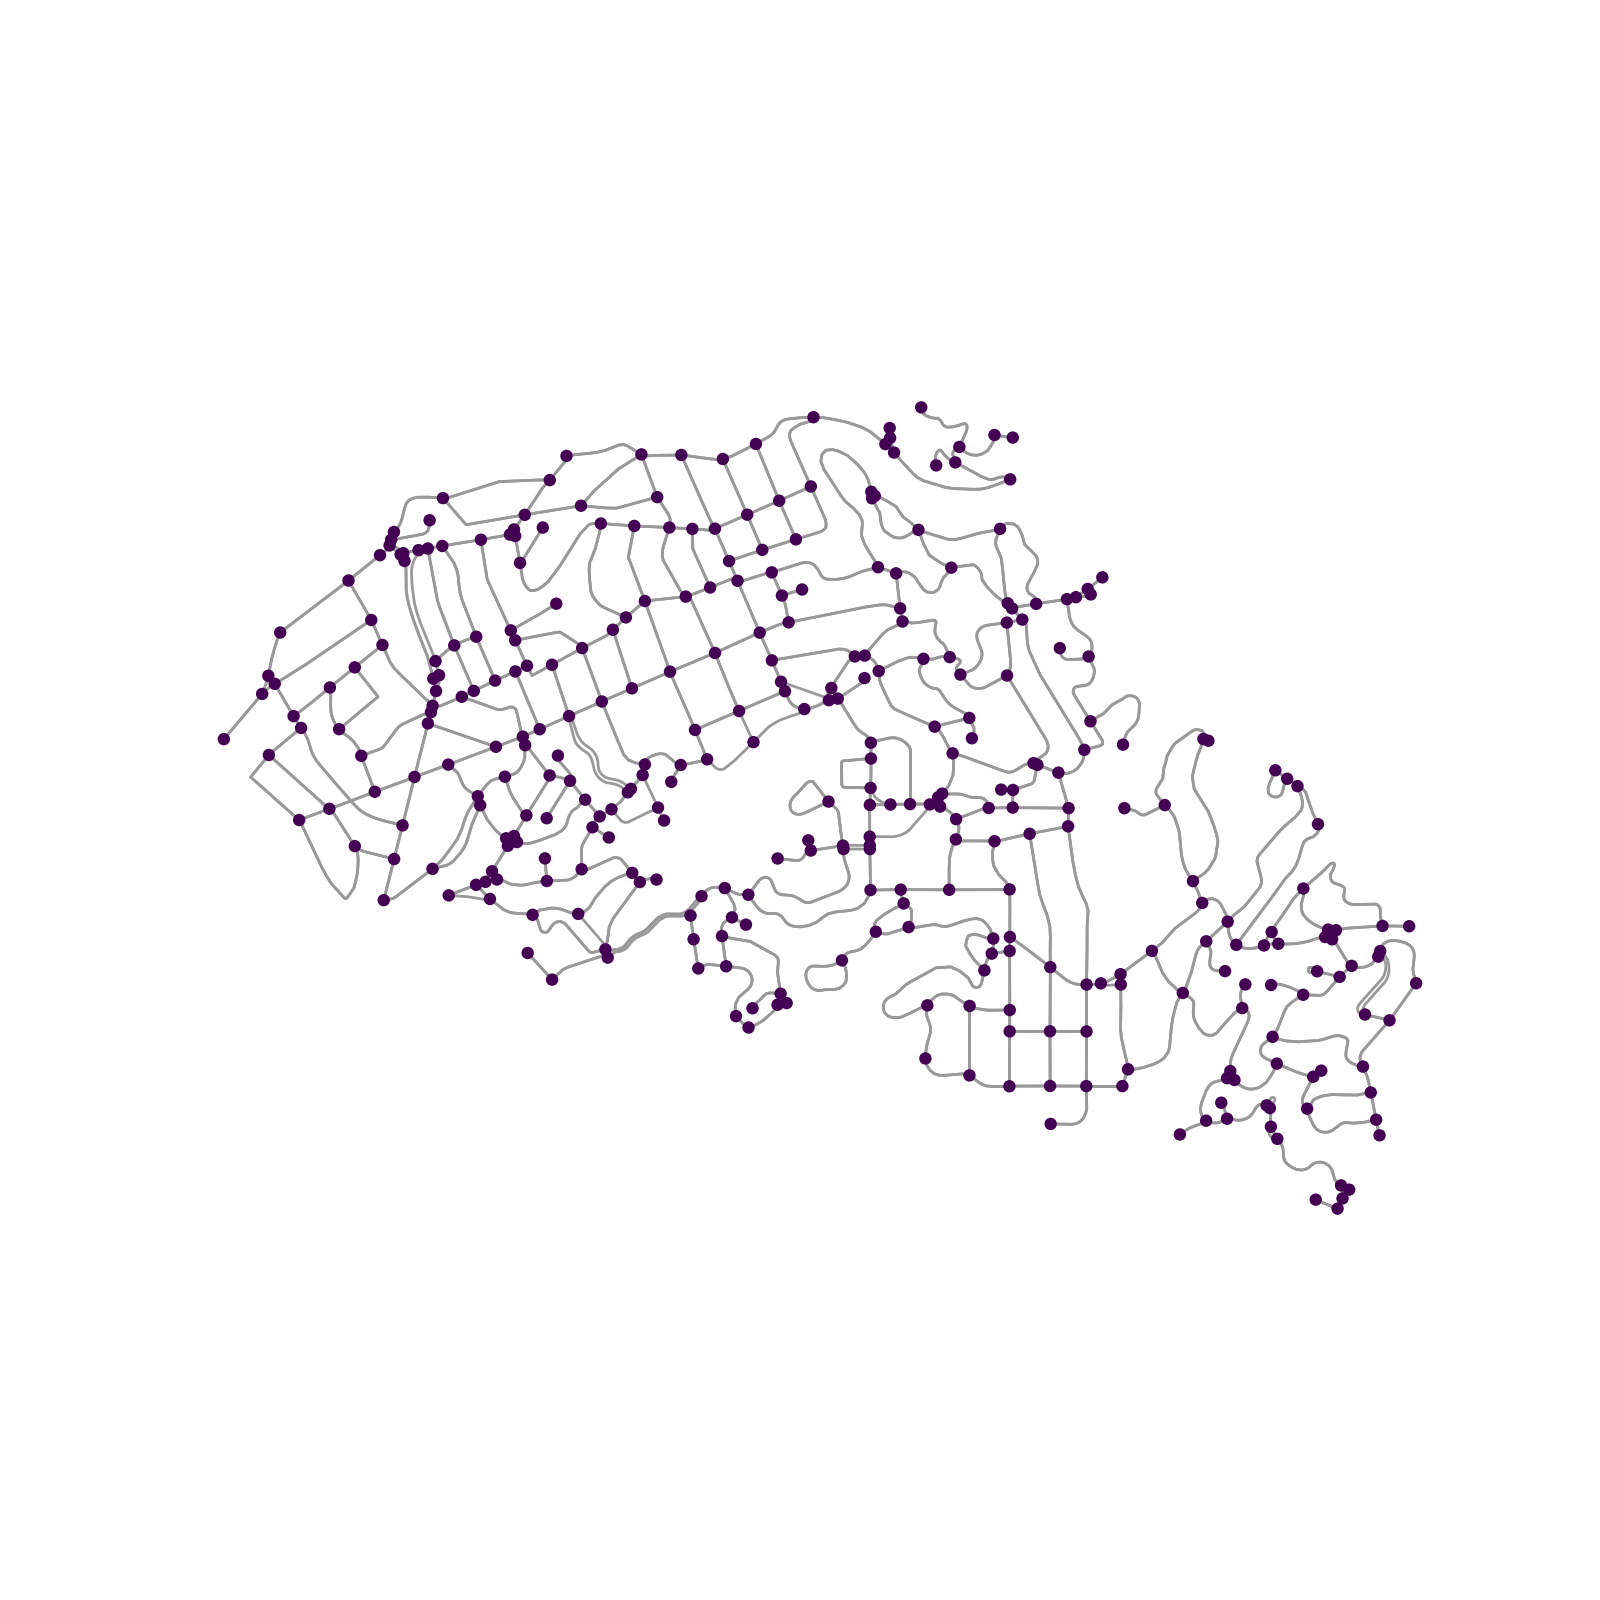

In [6]:
nc = ox.plot.get_node_colors_by_attr(G, "eta", cmap="viridis")
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=20,
    save=True,
    bgcolor="w",
)

Now, we get a watershed geometry using NLDI and then get the actual ET within its geometry.

In [7]:
geometry = NLDI().get_basins("01315500").geometry[0]

In [8]:
eta = gh.ssebopeta_bygeom(geometry, dates=dates)

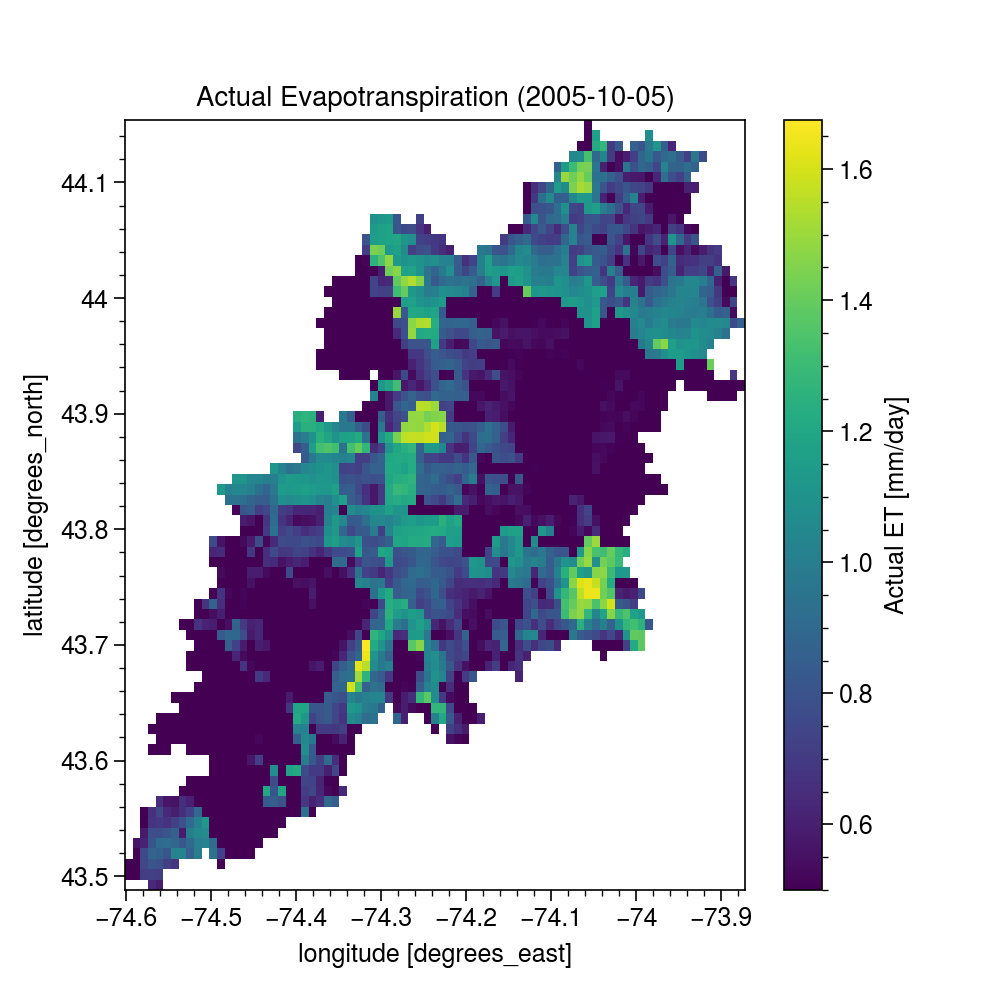

In [9]:
ax = eta.isel(time=4).plot(size=5)
date = eta.isel(time=4).time.dt.strftime("%Y-%m-%d").values
ax.axes.set_title(f"Actual Evapotranspiration ({date})")
ax.figure.savefig("_static/eta.png", bbox_inches="tight", facecolor="w")
ax.figure.savefig(Path("_static", "ssebop.png"), dpi=300, bbox_inches="tight", facecolor="w")